In [1]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.data.all import *
from fastai.callback import *

# SemTorch
from semtorch import get_segmentation_learner

# U²-Net metrics
from semtorch.utils.metrics import DiceUSquaredNet, JaccardCoeffUSquaredNet

from pathlib import Path
import random

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [2]:
%matplotlib inline
import numpy as np

Function por stablishing the seed for reproducibility

In [3]:
number_of_the_seed = 2020

random.seed(number_of_the_seed)
set_seed(number_of_the_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
path = Path("../datasets/")
path_images = path/"Images"
path_labels = path/"Labels"

test_name = "test"

Obtaining the label associated with an image, in the case of segmentation it is a mask

In [5]:
get_y_fn = lambda x: Path(str(x).replace("Images","Labels").replace(".png",".tif"))

Aux function for splitting between training and testing

In [6]:
def ParentSplitter(x):
    return Path(x).parent.name==test_name

Loading the codes of the different classes. All the datasets have the same codes.

In [7]:
codes = np.loadtxt(path/'codes.txt', dtype=str)

name2id = {v:k for k,v in enumerate(codes)}
print(name2id)
void_code = name2id['Tumor']

def tumour(input, target):
    input = input.squeeze(1)
    mask = target != void_code
    return (input[mask]==target[mask]).float().mean()

{'NoTumor': 0, 'Tumor': 1}


Early Stopping parameters

In [8]:
monitor_training="valid_loss"
comp_training=np.less

monitor_evaluating="dice"
comp_evaluating=np.greater

patience=2

In [9]:
from albumentations import (
    Compose,
    OneOf,
    ElasticTransform,
    GridDistortion, 
    OpticalDistortion,
    Flip,
    Rotate,
    Transpose,
    CLAHE,
    ShiftScaleRotate
)

In [10]:
class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0
    def __init__(self, aug): 
        self.aug = aug
    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])
    
transformPipeline=Compose([
                        Flip(p=0.5),
                        Transpose(p=0.5),
                        Rotate(p=0.40,limit=10)
                    ],p=1)

transformPipeline=SegmentationAlbumentationsTransform(transformPipeline)

In [11]:
class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass
    def encodes(self, x):
        img,mask = x
        
        #Convert to array
        mask = np.array(mask)
        
        # Change 255 for 1
        mask[mask==255]=1
        
        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In this concrete case, this model not requires a splitter for training owing to the fact that is training from scracth.

# U^2-Net

This model is just compatible with binary segmentation take this into account.

## Manual Annotations

In [12]:
manual_name="manual"

In [13]:
path_manual_img = path_images/manual_name
path_manual_lbl = path_labels/manual_name

../datasets/Images/manual/341.png


<AxesSubplot:>

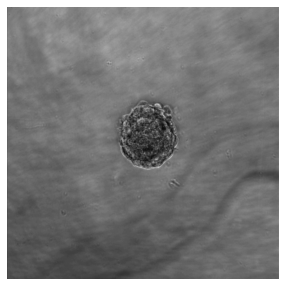

In [14]:
fnames_manual = get_image_files(path_manual_img)
lbl_names_manual = get_image_files(path_manual_lbl)

# open and show image
img_f = fnames_manual[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [15]:
print(get_y_fn(img_f))

../datasets/Labels/manual/341.tif


<AxesSubplot:>

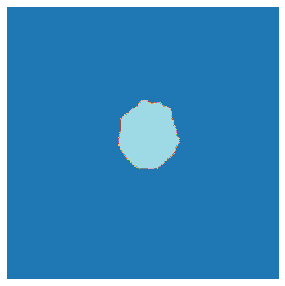

In [16]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [17]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [18]:
size = 1002
bs = 2

### No Data Augmentation

#### Hyper-parameter Selection

We are going to adjust weight decay.

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'me

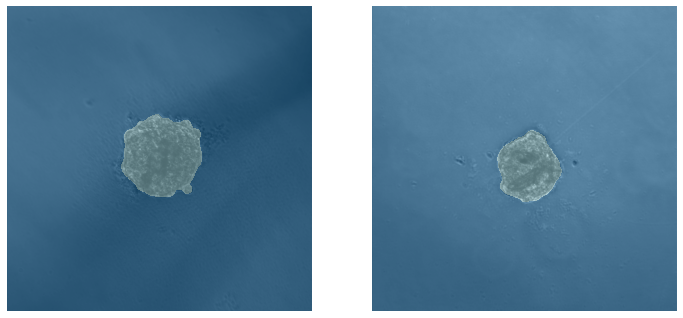

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-2).to_native_fp16()
#learn.freeze() # Freezing the backbone

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

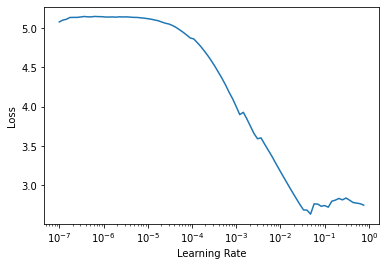

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.565065,0.285207,0.997693,0.937076,0.881603,02:38
1,0.633416,0.438873,0.994760,0.879358,0.784691,02:39
2,0.415720,0.217753,0.997173,0.930519,0.870065,02:39
3,0.320958,0.356853,0.997990,0.936792,0.881100,02:39
4,0.234089,0.155490,0.995806,0.955722,0.915199,02:39
5,0.172284,0.134815,0.996355,0.956992,0.917531,02:39
6,0.187076,0.159894,0.997024,0.947981,0.901106,02:39
7,0.130181,0.130415,0.996750,0.958012,0.919408,02:39
8,0.126528,0.119135,0.996415,0.960854,0.924657,02:39
9,0.093507,0.115636,0.996877,0.960385,0.923789,02:38


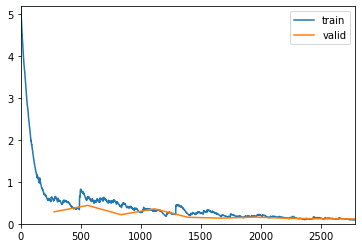

In [22]:
fname="u2net-manual-no-data-augmentation-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-no-data-augmentation-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.11564384400844574,0.996877133846283,0.9603816355483206,0.9237828691635799]

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-1).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

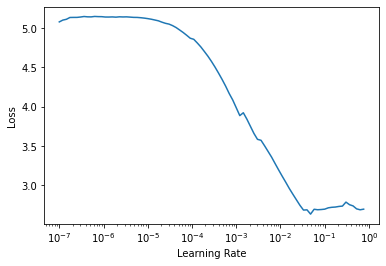

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.535167,0.396333,0.994399,0.923279,0.857492,02:38
1,0.560846,1.801804,0.988680,0.484678,0.319852,02:39
2,0.349487,0.178592,0.996623,0.951008,0.906592,02:39
3,0.345603,0.347995,0.997533,0.938061,0.883348,02:39
4,0.272047,0.141036,0.997263,0.958718,0.920710,02:39
5,0.149393,0.128764,0.995729,0.962294,0.927328,02:39
6,0.177166,0.152029,0.996565,0.953273,0.910719,02:39
7,0.111873,0.120515,0.997081,0.963807,0.930143,02:39
8,0.118786,0.111660,0.996750,0.965594,0.933477,02:39
9,0.087961,0.112641,0.997460,0.964610,0.931639,02:39


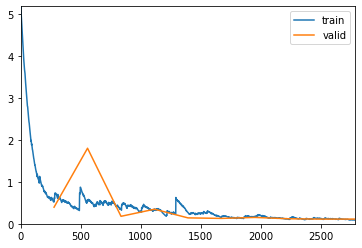

In [22]:
fname="u2net-manual-no-data-augmentation-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-no-data-augmentation-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.11164633184671402,0.9967482089996338,0.9655963789198707,0.9334812439186845]

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 'div_mask': 1} -> Normalize -- {'m

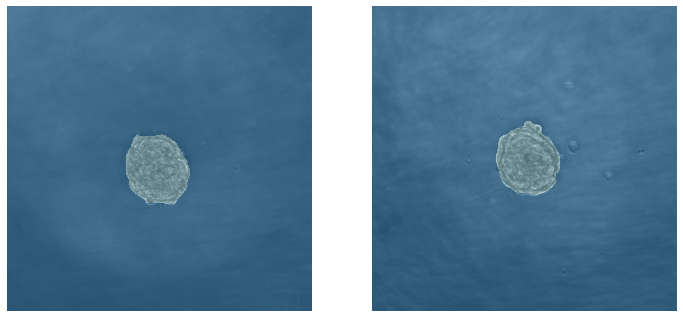

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-1).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

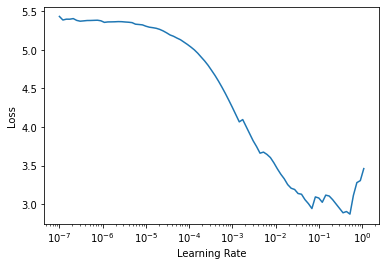

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.670085,1.228360,0.931725,0.694954,0.532513,03:15
1,0.375431,0.831882,0.940777,0.747316,0.596572,03:15
2,0.460903,0.709576,0.970015,0.820292,0.695335,03:16
3,0.232005,0.447325,0.980045,0.898427,0.815586,03:15
4,0.377724,1.863303,0.935078,0.748713,0.598354,03:15
5,0.228652,0.451162,0.989438,0.901015,0.819860,03:15
6,0.332114,0.555586,0.975433,0.874387,0.776809,03:15
7,0.208928,0.357767,0.993043,0.910140,0.835097,03:15
8,0.150452,0.355566,0.990417,0.913075,0.840053,03:15
9,0.151566,0.306560,0.991812,0.927557,0.864900,03:15


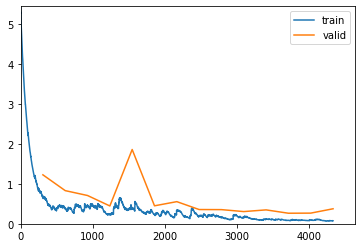

No improvement since epoch 11: early stopping


In [22]:
fname="u2net-manual-no-data-augmentation-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(15, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-no-data-augmentation-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.26519396901130676,0.9951210021972656,0.9394099410782705,0.8857427364851419]

In [22]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/u2net-dataset1-no-data-augmentation.pth")

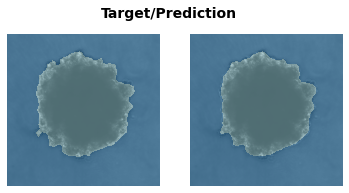

In [27]:
learn.show_results(vmin=0,vmax=1) # show results

### Data Augmentation

Setting-up type transforms pipelines
Found 621 items
2 datasets of sizes 559,62
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/165.png
    applying <lambda> gives
      ../datasets/Labels/manual/165.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

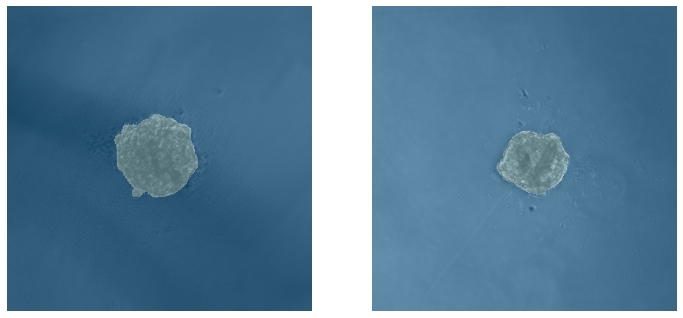

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-3).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

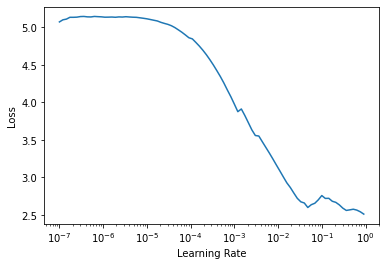

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.586662,0.303223,0.993685,0.944523,0.894877,02:39
1,0.546557,0.305596,0.994700,0.941277,0.889068,02:38
2,0.364699,0.203479,0.996613,0.945415,0.896481,02:39
3,0.416361,0.298237,0.998973,0.843048,0.728680,02:39
4,0.265201,0.159444,0.995370,0.951676,0.907808,02:39
5,0.153473,0.141612,0.995148,0.956286,0.916234,02:39
6,0.188601,0.137974,0.996659,0.957253,0.918011,02:39
7,0.141220,0.126001,0.996154,0.958732,0.920736,02:38
8,0.132022,0.111724,0.996358,0.962928,0.928507,02:39
9,0.097832,0.108170,0.996909,0.964040,0.930577,02:39


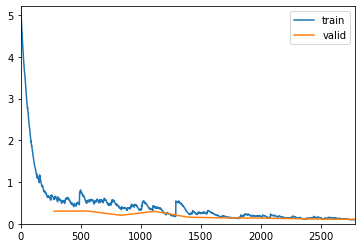

In [22]:
fname="u2net-manual-data-augmentation-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-data-augmentation-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.10816512256860733,0.9969069957733154,0.9640434709293453,0.9305829384503017]

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-2).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

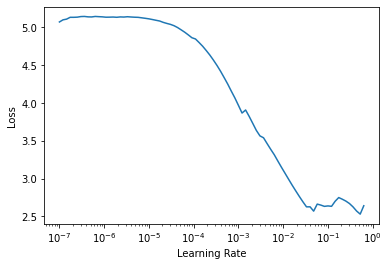

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.632937,0.348102,0.995996,0.943215,0.892532,02:38
1,0.583076,0.273114,0.994053,0.945821,0.897212,02:39
2,0.379204,0.186321,0.996330,0.946913,0.899178,02:39
3,0.380163,0.216589,0.997696,0.920296,0.852360,02:39
4,0.254463,0.158091,0.995254,0.953092,0.910387,02:39
5,0.146793,0.132591,0.996057,0.956800,0.917178,02:39
6,0.179023,0.135287,0.996875,0.955145,0.914141,02:39
7,0.134905,0.126360,0.996053,0.956250,0.916168,02:38
8,0.134829,0.127882,0.996225,0.956673,0.916945,02:38
9,0.091805,0.127532,0.996531,0.956236,0.916142,02:39


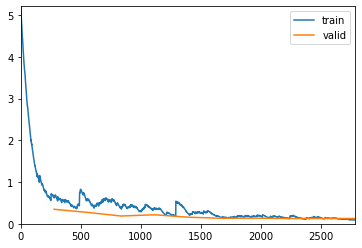

No improvement since epoch 7: early stopping


In [22]:
fname="u2net-manual-data-augmentation-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-data-augmentation-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.12639714777469635,0.9960506558418274,0.9562468399199594,0.9161618632576204]

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-1).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

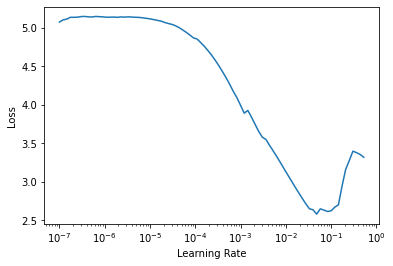

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.576491,0.312624,0.994148,0.951972,0.908345,02:44
1,0.598739,0.382442,0.993688,0.936763,0.881049,02:38
2,0.427526,0.204295,0.995476,0.937903,0.883068,02:38
3,0.385334,0.438877,0.999580,0.689158,0.525737,02:38
4,0.273074,0.158495,0.995828,0.947023,0.899376,02:38
5,0.142189,0.146906,0.995066,0.955538,0.914861,02:39
6,0.185314,0.126843,0.996724,0.955791,0.915326,02:39
7,0.126646,0.111914,0.996185,0.959012,0.921252,02:39
8,0.126549,0.113626,0.996342,0.958305,0.919948,02:39
9,0.094871,0.114657,0.996789,0.957651,0.918743,02:39


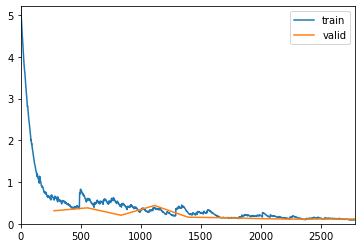

No improvement since epoch 7: early stopping


In [22]:
fname="u2net-manual-data-augmentation-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-data-augmentation-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.11191030591726303,0.9961836934089661,0.9590151504736747,0.9212575484744576]

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 987 items
2 datasets of sizes 621,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual/416.png
    applying <lambda> gives
      ../datasets/Labels/manual/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 25

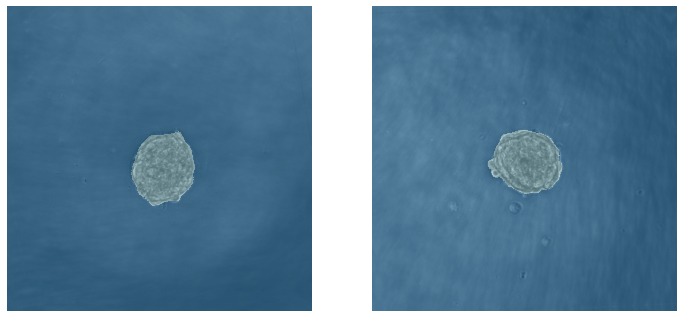

In [19]:
manual = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual.summary(path_images)
dls = manual.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-3).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

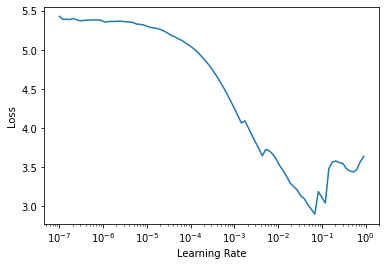

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.677700,1.045224,0.933663,0.718147,0.560241,03:16
1,0.443126,1.349576,0.956827,0.775356,0.633128,03:16
2,0.381012,0.746885,0.990035,0.812866,0.684730,03:16
3,0.222728,0.457075,0.982896,0.907439,0.830562,03:16
4,0.343621,2.232199,0.989649,0.685755,0.521786,03:15
5,0.159646,0.373892,0.991571,0.909609,0.834205,03:16
6,0.255328,0.591427,0.990826,0.851009,0.740657,03:15
7,0.183785,0.289302,0.992867,0.928022,0.865710,03:15
8,0.143553,0.533954,0.995292,0.875265,0.778196,03:15
9,0.139188,0.720125,0.997575,0.842661,0.728102,03:15


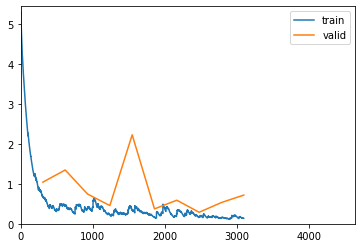

No improvement since epoch 7: early stopping


In [22]:
fname="u2net-manual-data-augmentation-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(15, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-data-augmentation-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.28931984305381775,0.9928695559501648,0.9280207819669103,0.8657078107070768]

In [22]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/u2net-dataset1-data-augmentation.pth")

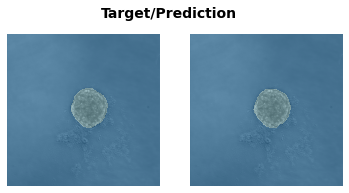

In [27]:
learn.show_results(vmin=0,vmax=1) # show results

## Manual + SpheroidJ Annotations

In [12]:
manual_spheroidj_name = "manual + spheroidj"

In [13]:
path_manual_plus_spheroidj_clear_img = path_images/manual_spheroidj_name
path_manual_plus_spheroidj_clear_lbl = path_labels/manual_spheroidj_name

../datasets/Images/manual + spheroidj/805.png


<AxesSubplot:>

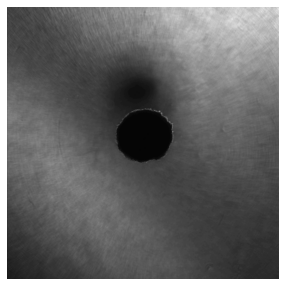

In [14]:
fnames_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_img)
lbl_names_manual_plus_spheroidj_clear = get_image_files(path_manual_plus_spheroidj_clear_lbl)

# open and show image
img_f = fnames_manual_plus_spheroidj_clear[10]
print(img_f)
img = PILImage.create(img_f)
img.show(figsize=(5, 5))

In [15]:
print(get_y_fn(img_f))

../datasets/Labels/manual + spheroidj/805.tif


<AxesSubplot:>

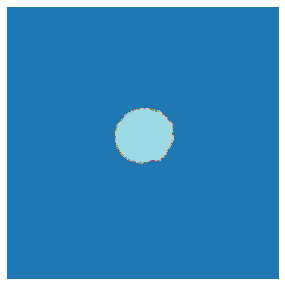

In [16]:
mask = PILMask.create(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [17]:
print(torch.max(image2tensor(mask)))

tensor(255, dtype=torch.uint8)


In [18]:
size = 1002
bs = 2

### No Data Augmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255.0, 

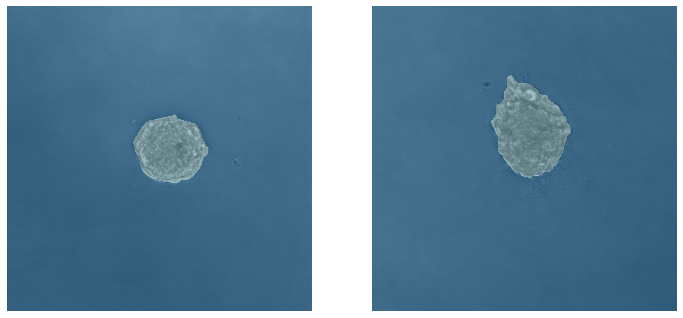

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                   batch_tfms=Normalize.from_stats(*imagenet_stats)
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-4).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

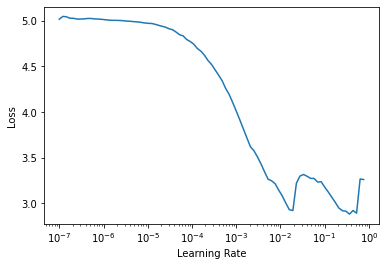

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.393465,1.231426,0.994981,0.086764,0.045349,04:32
1,0.458284,0.342169,0.989459,0.941414,0.889314,04:33
2,0.237245,0.790786,0.981298,0.848952,0.737548,04:34
3,0.296477,0.262584,0.994225,0.948208,0.901517,04:40
4,0.193163,0.222078,0.992806,0.950445,0.905570,04:36
5,0.176686,0.161276,0.995312,0.964352,0.931159,04:34
6,0.146504,0.154024,0.995838,0.962910,0.928472,04:34
7,0.126708,0.175267,0.992542,0.960625,0.924233,04:34
8,0.109592,0.143261,0.994064,0.966076,0.934379,04:35
9,0.105826,0.136397,0.994532,0.966864,0.935854,04:34


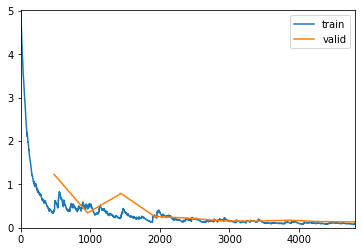

In [22]:
fname="u2net-manual-spheroidj-no-data-augmentation-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-no-data-augmentation-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.1363975703716278,0.9945293664932251,0.9668615420537854,0.9358489509487609]

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-3).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

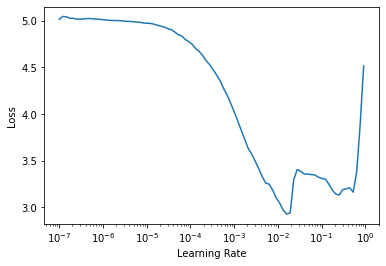

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.359885,0.765705,0.994681,0.841264,0.726019,04:33
1,0.507958,0.454368,0.996526,0.871849,0.772812,04:33
2,0.230263,0.292195,0.994509,0.944493,0.894823,04:32
3,0.316980,0.448907,0.996028,0.908277,0.831967,04:31
4,0.197750,0.166767,0.996131,0.963437,0.929454,04:31
5,0.170430,0.171340,0.996525,0.959445,0.922052,04:31
6,0.148843,0.141482,0.997846,0.967744,0.937505,04:31
7,0.116869,0.115510,0.995958,0.971520,0.944616,04:30
8,0.085225,0.113713,0.996677,0.971649,0.944860,04:30
9,0.076975,0.116993,0.997504,0.973070,0.947552,04:31


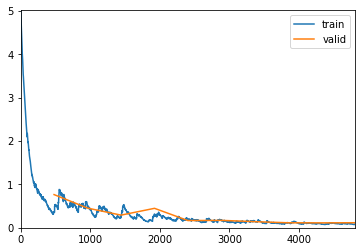

In [22]:
fname="u2net-manual-spheroidj-no-data-augmentation-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-no-data-augmentation-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.11371295154094696,0.9966757297515869,0.9716498377299905,0.944862823364702]

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-2).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

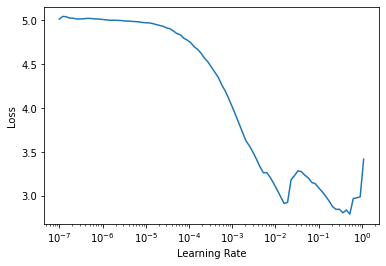

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.384685,0.643486,0.996049,0.837233,0.720036,04:33
1,0.444097,0.343798,0.992881,0.930501,0.870034,04:33
2,0.273146,0.849720,0.999255,0.741810,0.589585,04:31
3,0.300316,0.446138,0.997120,0.898323,0.815414,04:30


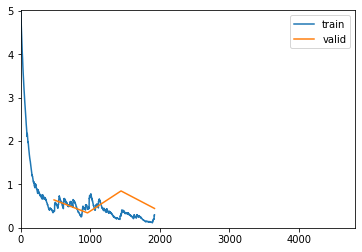

No improvement since epoch 1: early stopping


In [22]:
fname="u2net-manual-spheroidj-no-data-augmentation-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-no-data-augmentation-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.34377872943878174,0.9928750991821289,0.9305078022508475,0.8700463679951936]

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-1).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

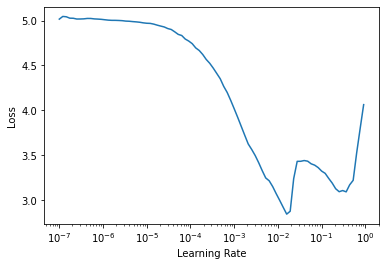

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.446734,0.925874,0.970587,0.348040,0.210683,04:31
1,0.577577,2.939111,0.884592,0.646467,0.477615,04:32
2,0.185146,0.285091,0.994756,0.949887,0.904558,04:31
3,0.499082,0.364587,0.995015,0.944527,0.894884,04:32
4,0.243603,0.219578,0.994909,0.954213,0.912435,04:33
5,0.179166,0.184153,0.994316,0.960073,0.923211,04:32
6,0.145665,0.173269,0.998463,0.961718,0.926260,04:32
7,0.127695,0.132869,0.995399,0.967009,0.936125,04:33
8,0.094905,0.138839,0.995651,0.967517,0.937077,04:32
9,0.104096,0.134541,0.996636,0.969894,0.941547,04:31


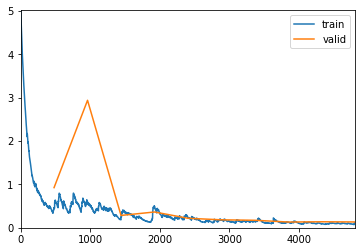

No improvement since epoch 7: early stopping


In [22]:
fname="u2net-manual-spheroidj-no-data-augmentation-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-no-data-augmentation-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.1328744888305664,0.9953951835632324,0.9670059256766608,0.9361195283817055]

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeline: IntToFloatTensor -- {'div': 255

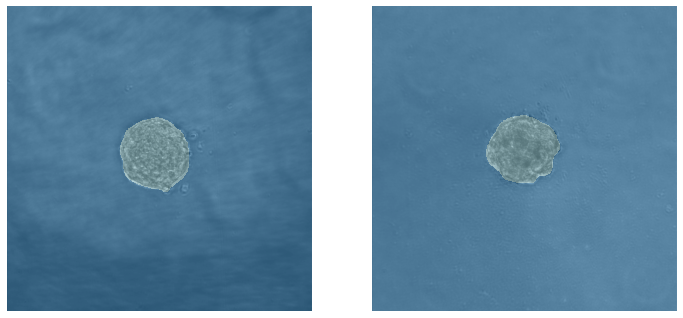

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                                     get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                                     get_y=get_y_fn,
                                     splitter=FuncSplitter(ParentSplitter),
                                     item_tfms=[Resize((size,size)), TargetMaskConvertTransform()],
                                     batch_tfms=Normalize.from_stats(*imagenet_stats)
                          )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-3).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

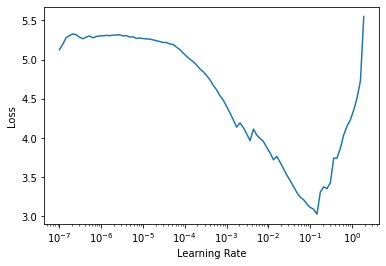

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.620816,0.525780,0.991522,0.882770,0.790142,05:19
1,0.311891,1.738932,0.901352,0.680562,0.515796,05:19
2,0.308531,0.275192,0.988078,0.941357,0.889211,05:20
3,0.304920,0.226834,0.991711,0.949803,0.904405,05:20
4,0.239928,0.246328,0.990873,0.946321,0.898111,05:22
5,0.160684,0.188622,0.994166,0.955066,0.913997,05:22
6,0.128744,0.161481,0.995478,0.961738,0.926296,05:18
7,0.144081,0.153676,0.994116,0.961891,0.926580,05:17
8,0.129800,0.144913,0.996665,0.964050,0.930596,05:18
9,0.119518,0.175865,0.997961,0.960870,0.924686,05:19


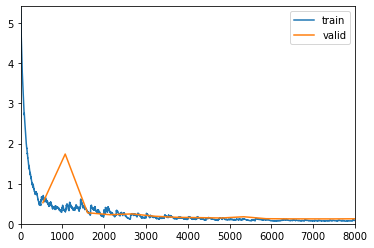

No improvement since epoch 12: early stopping


In [22]:
fname="u2net-manual-spheroidj-no-data-augmentation-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(15, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-no-data-augmentation-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.1224493756890297,0.996390163898468,0.9723931734876936,0.946269670850662]

In [22]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/u2net-dataset3-no-data-augmentation.pth")

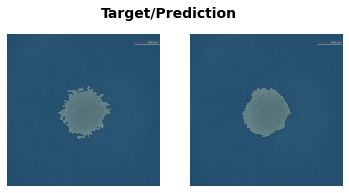

In [24]:
learn.show_results(vmin=0,vmax=1) # show results

### DataAugmentation

Setting-up type transforms pipelines
Found 1069 items
2 datasets of sizes 963,106
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/42.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/42.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pipeli

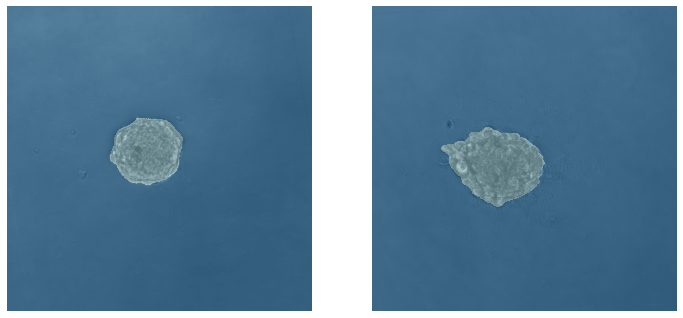

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name]),
                   get_y=get_y_fn,
                   splitter=RandomSplitter(valid_pct=0.1,seed=2020),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

WD=1e-4

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-4).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

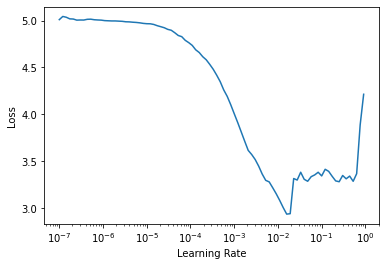

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.433266,0.427822,0.983735,0.912499,0.839078,04:36
1,0.431155,1.855842,0.998385,0.703419,0.542519,04:33
2,0.175355,0.224029,0.996337,0.952219,0.908795,04:31
3,0.307995,0.279335,0.995257,0.938407,0.883961,04:32
4,0.249573,0.188487,0.996187,0.955898,0.915521,04:34
5,0.190142,0.209487,0.992246,0.955275,0.914379,04:41
6,0.168742,0.163674,0.995631,0.962072,0.926917,04:35
7,0.136837,0.141962,0.995050,0.966297,0.934792,04:32
8,0.113991,0.133187,0.995013,0.967092,0.936280,04:38
9,0.116204,0.131877,0.996531,0.968772,0.939436,04:35


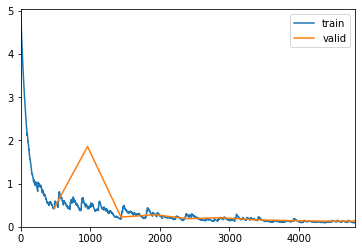

In [22]:
fname="u2net-manual-spheroidj-data-augmentation-WD-4-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-data-augmentation-WD-4-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.13188478350639343,0.9965280294418335,0.9687698167763525,0.939431208023758]

WD=1e-3

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-3).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

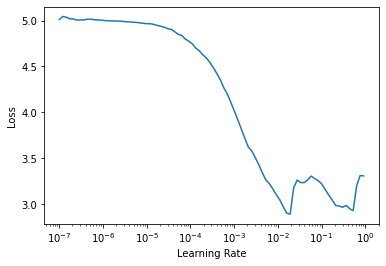

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.373928,0.410220,0.995504,0.932973,0.874367,04:35
1,0.579328,0.810899,0.998454,0.733441,0.579082,04:34
2,0.210698,0.269135,0.994195,0.947871,0.900908,04:32
3,0.289400,0.214731,0.995831,0.956549,0.916716,04:37
4,0.201948,0.200091,0.993189,0.957079,0.917691,04:36
5,0.196549,0.153449,0.995075,0.963051,0.928735,04:35
6,0.164112,0.162017,0.996121,0.961786,0.926386,04:33
7,0.134118,0.131682,0.995393,0.967257,0.936590,04:33
8,0.120457,0.111476,0.996798,0.972629,0.946717,04:32
9,0.113314,0.119386,0.998168,0.972646,0.946749,04:31


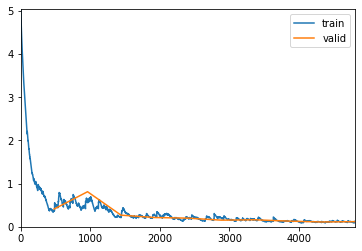

In [22]:
fname="u2net-manual-spheroidj-data-augmentation-WD-3-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-data-augmentation-WD-3-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.11147052049636841,0.9967935085296631,0.9726221832106405,0.9467035080143789]

WD=1e-2

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-2).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

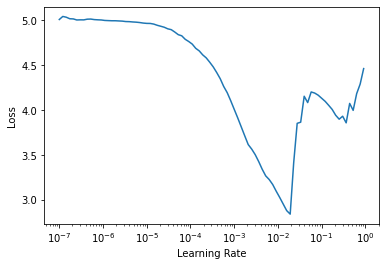

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.434026,0.547504,0.989679,0.852583,0.743045,04:36
1,0.470974,1.574544,0.997073,0.752021,0.602591,04:40
2,0.222060,0.353014,0.992189,0.937693,0.882695,04:36
3,0.351786,0.560684,0.979053,0.904880,0.826283,04:35
4,0.208560,0.205171,0.991777,0.952676,0.909628,04:34
5,0.191939,0.158543,0.995660,0.964565,0.931556,04:34
6,0.155055,0.142480,0.997701,0.964590,0.931602,04:34
7,0.122476,0.107823,0.996945,0.974014,0.949345,04:33
8,0.111383,0.112461,0.997151,0.972138,0.945786,04:33
9,0.089674,0.114979,0.998006,0.970214,0.942151,04:32


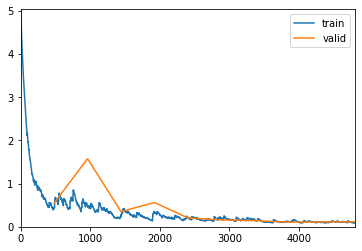

No improvement since epoch 7: early stopping


In [22]:
fname="u2net-manual-spheroidj-data-augmentation-WD-2-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-data-augmentation-WD-2-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.10782583802938461,0.9969428181648254,0.974013321108348,0.949343048157848]

WD=1e-1

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-1).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

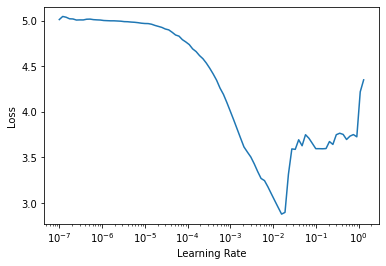

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.388906,0.701674,0.992490,0.863425,0.759672,04:33
1,0.397092,0.372175,0.989722,0.937720,0.882743,04:35
2,0.178521,0.254022,0.996054,0.943943,0.893838,04:34
3,0.300036,0.256411,0.996478,0.937070,0.881592,04:35
4,0.227521,0.212204,0.995006,0.957128,0.917781,04:33
5,0.185115,0.148135,0.996436,0.967234,0.936547,04:34
6,0.149965,0.159321,0.996713,0.965520,0.933339,04:35
7,0.125087,0.112244,0.996175,0.973847,0.949026,04:34
8,0.106229,0.111422,0.996546,0.971704,0.944966,04:35
9,0.107380,0.112816,0.997216,0.970844,0.943339,04:34


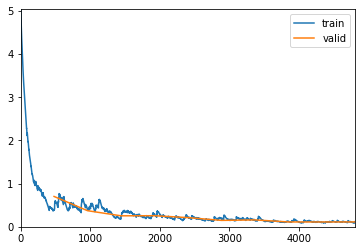

In [22]:
fname="u2net-manual-spheroidj-data-augmentation-WD-1-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_training,comp=comp_training, patience=patience),
    SaveModelCallback(monitor=monitor_training,comp=comp_training,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(10, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-data-augmentation-WD-1-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.1114443764090538,0.996541440486908,0.9716990817936801,0.944955960448454]

#### Evaluation - Best hyperparameters

Setting-up type transforms pipelines
Found 1435 items
2 datasets of sizes 1069,366
Setting up Pipeline: PILBase.create
Setting up Pipeline: <lambda> -> PILBase.create

Building one sample
  Pipeline: PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying PILBase.create gives
      PILImage mode=RGB size=1002x1004
  Pipeline: <lambda> -> PILBase.create
    starting from
      ../datasets/Images/manual + spheroidj/416.png
    applying <lambda> gives
      ../datasets/Labels/manual + spheroidj/416.tif
    applying PILBase.create gives
      PILMask mode=L size=1002x1004

Final sample: (PILImage mode=RGB size=1002x1004, PILMask mode=L size=1002x1004)


Setting up after_item: Pipeline: AddMaskCodes -> TargetMaskConvertTransform -> SegmentationAlbumentationsTransform -> Resize -- {'size': (1002, 1002), 'method': 'crop', 'pad_mode': 'reflection', 'resamples': (2, 0), 'p': 1.0} -> ToTensor
Setting up before_batch: Pipeline: 
Setting up after_batch: Pi

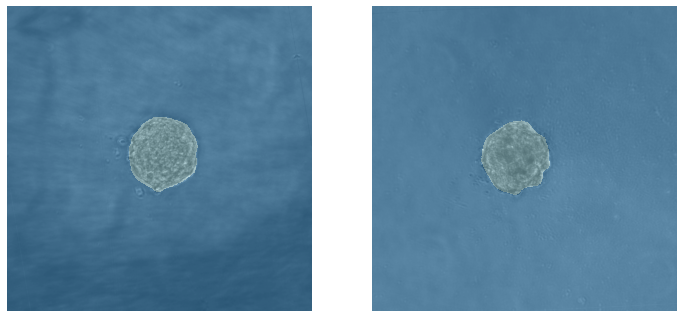

In [19]:
manual_spheroidj_clear = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items=partial(get_image_files,folders=[manual_spheroidj_name,test_name]),
                   get_y=get_y_fn,
                   splitter=FuncSplitter(ParentSplitter),
                   item_tfms=[Resize((size,size)), TargetMaskConvertTransform(), transformPipeline],
                   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
                  )
manual_spheroidj_clear.summary(path_images)
dls = manual_spheroidj_clear.dataloaders(path_images,bs=bs)
dls.show_batch(vmin=0,vmax=1,figsize=(12, 9))

In [20]:
learn = get_segmentation_learner(dls=dls, number_classes=2, segmentation_type="Semantic Segmentation",
                                 architecture_name="u2^net", backbone_name="small", 
                                 metrics=[tumour, DiceUSquaredNet(), JaccardCoeffUSquaredNet()],wd=1e-2).to_native_fp16()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3011: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


Recorder

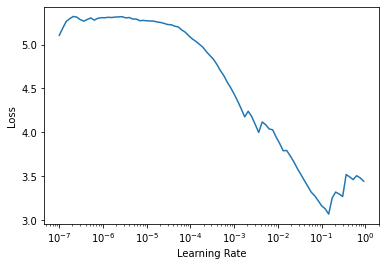

In [21]:
learn.lr_find() # find learning rate
learn.recorder # plot learning rate graph

epoch,train_loss,valid_loss,tumour,dice,jaccard_coeff,time
0,0.561142,0.513201,0.992499,0.864237,0.760931,05:19
1,0.329088,0.336313,0.990342,0.928590,0.866700,05:19
2,0.347650,0.333984,0.995745,0.925318,0.861015,05:22
3,0.299033,0.267758,0.990099,0.935862,0.879456,05:21
4,0.306741,0.319300,0.995949,0.927214,0.864305,05:17
5,0.208325,0.248823,0.990252,0.950317,0.905338,05:18
6,0.198300,0.390755,0.995688,0.923072,0.857134,05:17
7,0.172132,0.181093,0.992867,0.957268,0.918038,05:17
8,0.147656,0.137256,0.995747,0.963406,0.929396,05:18
9,0.142316,0.182966,0.997379,0.958759,0.920785,05:18


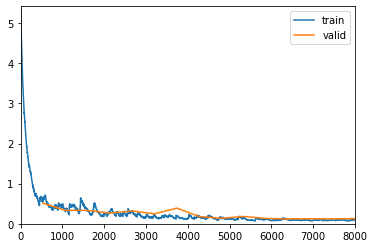

In [22]:
fname="u2net-manual-spheroidj-data-augmentation-best"

callbacksFitBeforeUnfreeze = [
    ShowGraphCallback(),
    EarlyStoppingCallback(monitor=monitor_evaluating,comp=comp_evaluating, patience=patience),
    SaveModelCallback(monitor=monitor_evaluating,comp=comp_evaluating,every_epoch=False,fname=fname)  
]
learn.fit_one_cycle(15, slice(1e-4,1e-3),cbs=callbacksFitBeforeUnfreeze)

In [21]:
learn.load("u2net-manual-spheroidj-data-augmentation-best")
learn.validate()

/home/david/anaconda3/envs/Deep-Tumour-Spheroid/lib/python3.7/site-packages/torch/nn/functional.py:3122: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


(#4) [0.12207131087779999,0.9961803555488586,0.9695325281352825,0.9408666984711627]

In [22]:
aux=learn.model
aux=aux.cpu()

traced_cell=torch.jit.script(aux)
traced_cell.save("TorchScript models/u2net-dataset3-data-augmentation.pth")

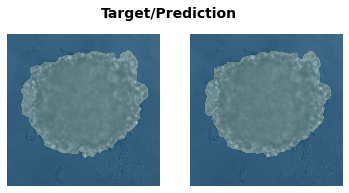

In [28]:
learn.show_results(vmin=0,vmax=1) # show results